<a href="https://colab.research.google.com/github/EstefRZ99/data-analysis-explorations/blob/main/mining_association.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

En el presente informe se describe el proceso de análisis de asociaciones en un conjunto de datos transaccional, utilizando el archivo orders.csv. Este dataset contiene información sobre transacciones individuales en las que se listan productos comprados en cada pedido.

El objetivo principal es aplicar la técnica de minería por asociación utilizando el algoritmo Apriori, identificar itemsets frecuentes y generar reglas de asociación que permitan detectar qué productos se compran juntos de forma habitual. Para ello, se realizó el preprocesamiento de los datos, se transformaron las transacciones a un formato one-hot y se ajustaron parámetros como el soporte mínimo y la longitud máxima de los itemsets, con el fin de optimizar el consumo de memoria y obtener resultados consistentes.

Además, se realizaron visualizaciones en forma de gráfico de red para representar las asociaciones y se construyó una tabla resumen que facilita la interpretación de las relaciones detectadas.


**Desarrollo**

In [ ]:
# 1. Cargar el dataset
pedidos = pd.read_csv("orders.csv", sep=";")
print("Primeras filas del dataset:")
print(pedidos.head())

Primeras filas del dataset:
   order_id           product_name
0         2     Organic Egg Whites
1         2  Michigan Organic Kale
2         2          Garlic Powder
3         2         Coconut Butter
4         2      Natural Sweetener


In [ ]:

# 2. Agrupar los ítems por transacción (order_id)
# Cada transacción es una lista de productos
transacciones = pedidos.groupby("order_id")["product_name"].apply(list).values.tolist()

In [ ]:

# 3. Inspeccionar el tamaño de cada transacción
tamanhos_trans = [len(trans) for trans in transacciones]
print("\nTamaño de las primeras transacciones:", tamanhos_trans[:6])


Tamaño de las primeras transacciones: [9, 8, 13, 26, 3, 2]


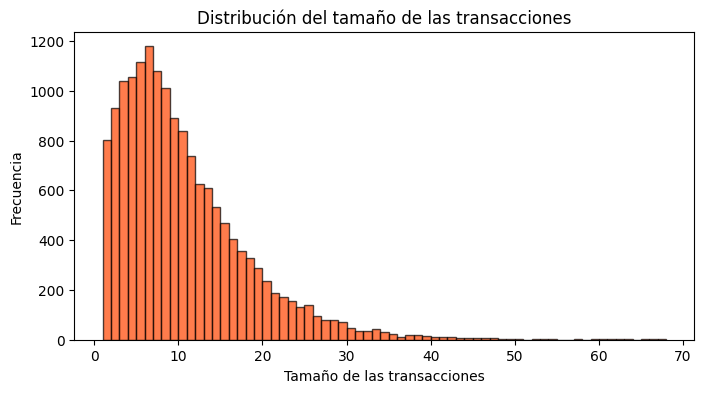


Resumen de tamaños de transacciones:
count    15994.000000
mean        10.088596
std          7.534649
min          1.000000
25%          5.000000
50%          8.000000
75%         14.000000
max         68.000000
dtype: float64


In [ ]:
# 4. Visualizar la distribución del tamaño de las transacciones
plt.figure(figsize=(8,4))
plt.hist(tamanhos_trans, bins=range(1, max(tamanhos_trans)+1), color='orangered', edgecolor='black', alpha=0.7)
plt.xlabel("Tamaño de las transacciones")
plt.ylabel("Frecuencia")
plt.title("Distribución del tamaño de las transacciones")
plt.show()

print("\nResumen de tamaños de transacciones:")
print(pd.Series(tamanhos_trans).describe())

In [ ]:
# 5. Filtrar transacciones que tengan al menos 2 ítems
transacciones_filtradas = [trans for trans in transacciones if len(trans) > 1]
print("\nNúmero total de transacciones (original):", len(transacciones))
print("Número total de transacciones (filtradas):", len(transacciones_filtradas))



Número total de transacciones (original): 15994
Número total de transacciones (filtradas): 15191


In [ ]:
# trabajar con una muestra pequeña para pruebas (por ejemplo, 10% de las transacciones)
usar_muestra = False  # Cambia a True para probar con una muestra
if usar_muestra:
    muestra = random.sample(transacciones_filtradas, int(len(transacciones_filtradas) * 0.1))
    trans_data = muestra
    print("\nTrabajando con una muestra del 10% de las transacciones.")
else:
    trans_data = transacciones_filtradas

In [ ]:
# 6. Convertir las transacciones a una matriz booleana (formato one-hot)
te = TransactionEncoder()
te_array = te.fit(trans_data).transform(trans_data)
df_trans = pd.DataFrame(te_array, columns=te.columns_)
print("\nVista parcial de la matriz de transacciones:")
print(df_trans.head())


Vista parcial de la matriz de transacciones:
   #2 Coffee Filters  & Go! Hazelnut Spread + Pretzel Sticks  \
0              False                                   False   
1              False                                   False   
2              False                                   False   
3              False                                   False   
4              False                                   False   

   0 Calorie Strawberry Dragonfruit Water Beverage  \
0                                            False   
1                                            False   
2                                            False   
3                                            False   
4                                            False   

   0% Fat Black Cherry Greek Yogurt y  0% Fat Blueberry Greek Yogurt  \
0                               False                          False   
1                               False                          False   
2                           

In [ ]:
# 7. Calcular la frecuencia (soporte) de cada ítem (opcional)
item_frequency = df_trans.mean()  # Proporción de transacciones en las que aparece cada ítem
print("\nFrecuencia de algunos ítems:")
print(item_frequency.head())



Frecuencia de algunos ítems:
#2 Coffee Filters                                  0.000132
& Go! Hazelnut Spread + Pretzel Sticks             0.000132
0 Calorie Strawberry Dragonfruit Water Beverage    0.000066
0% Fat Black Cherry Greek Yogurt y                 0.000066
0% Fat Blueberry Greek Yogurt                      0.000197
dtype: float64


In [ ]:
# 8. Definir el soporte mínimo. En lugar de usar el soporte muy bajo del ejemplo original, usaremos un 1%
min_support = 0.01  # Puedes ajustar este valor según los resultados
print("\nSoporte mínimo definido:", min_support)


Soporte mínimo definido: 0.01


In [ ]:
# 9. Calcular los itemsets frecuentes usando Apriori limitando la longitud máxima de los itemsets a 3
frequent_itemsets = apriori(df_trans,
                            min_support=min_support,
                            use_colnames=True,
                            max_len=3)
frequent_itemsets = frequent_itemsets.sort_values(by="support", ascending=False)
print("\nItemsets frecuentes (vista parcial):")
print(frequent_itemsets.head())


Itemsets frecuentes (vista parcial):
     support                  itemsets
6   0.157462                  (Banana)
5   0.124218  (Bag of Organic Bananas)
79  0.081825    (Organic Strawberries)
38  0.076361    (Organic Baby Spinach)
59  0.070107    (Organic Hass Avocado)


In [ ]:
# 10. Generar reglas de asociación con un umbral mínimo de confianza del 70%
min_confidence = 0.7
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
rules = rules.sort_values(by="confidence", ascending=False)
print("\nReglas de asociación generadas:")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Reglas de asociación generadas:
Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


Número de nodos en el grafo: 13
Número de aristas en el grafo: 18


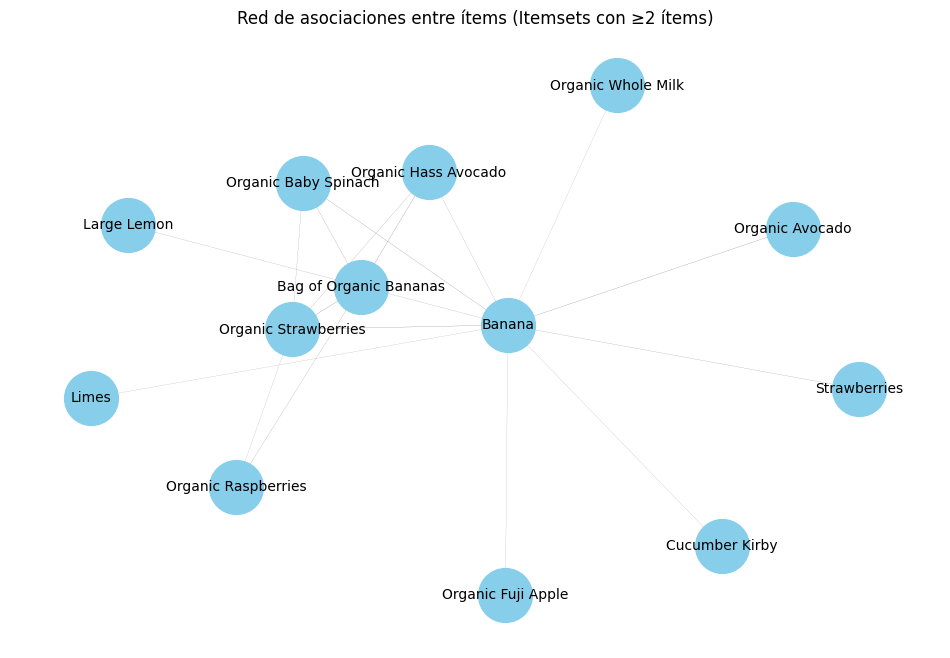

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Filtrar itemsets que contengan más de un ítem
frequent_itemsets_multi = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) >= 2)]

if frequent_itemsets_multi.empty:
    print("No hay itemsets con más de un ítem para construir un grafo de asociaciones.")
    print("Mostrando una gráfica de barras de los itemsets frecuentes de un solo ítem.")

    # Filtrar itemsets de un solo ítem y ordenar por soporte
    frequent_itemsets_single = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) == 1)]
    top_items = frequent_itemsets_single.sort_values('support', ascending=False).head(10)

    plt.figure(figsize=(8,6))
    # Extraer el ítem (como string) de cada conjunto
    items = [list(x)[0] for x in top_items['itemsets']]
    plt.barh(items, top_items['support'], color='skyblue')
    plt.xlabel("Soporte")
    plt.title("Itemsets Frecuentes (ítems individuales)")
    plt.gca().invert_yaxis()
    plt.show()

else:
    # Crear un grafo no dirigido para representar las asociaciones
    G = nx.Graph()

    # Por cada itemset con más de un ítem, agregar aristas entre cada par de ítems.
    for _, row in frequent_itemsets_multi.iterrows():
        items = list(row['itemsets'])
        for i in range(len(items)):
            for j in range(i+1, len(items)):
                # Si ya existe la arista, se puede sumar el soporte para reflejar múltiples apariciones.
                if G.has_edge(items[i], items[j]):
                    G[items[i]][items[j]]['weight'] += row['support']
                else:
                    G.add_edge(items[i], items[j], weight=row['support'])

    # Mostrar cantidad de nodos y aristas para confirmar
    print("Número de nodos en el grafo:", len(G.nodes()))
    print("Número de aristas en el grafo:", len(G.edges()))

    # Posicionar los nodos con spring_layout
    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12,8))
    # Dibujar nodos
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1500)
    # Dibujar aristas con ancho proporcional al peso (multiplicamos para mayor visibilidad)
    edges = G.edges(data=True)
    widths = [d['weight'] * 10 for (u, v, d) in edges]
    nx.draw_networkx_edges(G, pos, width=widths, edge_color='gray')
    # Dibujar etiquetas
    nx.draw_networkx_labels(G, pos, font_size=10)

    plt.title("Red de asociaciones entre ítems (Itemsets con ≥2 ítems)")
    plt.axis('off')
    plt.show()


In [ ]:
import pandas as pd

# Crear una lista de diccionarios a partir de las aristas del grafo G
edge_data = []
for u, v, data in G.edges(data=True):
    edge_data.append({'Item 1': u, 'Item 2': v, 'Weight': data['weight']})

# Convertir la lista en un DataFrame
df_associations = pd.DataFrame(edge_data)

# Ordenar la tabla según el peso (mayor a menor) y mostrar las primeras 10 filas
df_associations = df_associations.sort_values(by='Weight', ascending=False)
print("Tabla de asociaciones (primeras 10 filas):")
print(df_associations.head(10))


Tabla de asociaciones (primeras 10 filas):
                    Item 1                  Item 2    Weight
0     Organic Hass Avocado  Bag of Organic Bananas  0.019354
7     Organic Strawberries                  Banana  0.019222
4   Bag of Organic Bananas    Organic Strawberries  0.018432
10                  Banana         Organic Avocado  0.018234
11                  Banana    Organic Baby Spinach  0.017379
5   Bag of Organic Bananas    Organic Baby Spinach  0.015799
12                  Banana            Strawberries  0.014219
6   Bag of Organic Bananas     Organic Raspberries  0.013890
8     Organic Strawberries    Organic Baby Spinach  0.013297
1     Organic Hass Avocado    Organic Strawberries  0.012968


**Conclusiones**


En este informe se exploró la aplicación de la técnica de minería por asociación sobre el dataset orders.csv usando Python. Se pudo observar cómo, paso a paso, es posible transformar datos transaccionales en información valiosa. Primero se realizó un preprocesamiento que incluyó la agrupación de ítems por cada pedido y la eliminación de transacciones con menos de dos ítems, asegurando que el análisis se realizara sobre datos consistentes.

Luego, mediante el uso del algoritmo Apriori—con un soporte mínimo ajustado al 1% y limitando la longitud de los itemsets a 3—se identificaron los patrones más frecuentes. A partir de estos patrones se generaron reglas de asociación con un umbral de confianza del 70%, lo que permitió descubrir relaciones interesantes entre productos que se compran juntos de forma habitual.

Además, la creación de un gráfico de red facilitó la visualización de estas asociaciones, haciendo más intuitivo comprender cómo se relacionan los diferentes ítems. Finalmente, se generó una tabla resumen que condensó esta información, ofreciendo una perspectiva clara y ordenada de las asociaciones encontradas.

Por último, este enfoque en Python, utilizando librerías como mlxtend y networkx, no solo replica lo que se podía hacer con herramientas tradicionales en R, sino que además ofrece una gran flexibilidad y poder visual. El análisis realizado no solo abre la puerta a optimizar estrategias de marketing y mejorar la gestión de inventarios, sino que también proporciona una base sólida para entender el comportamiento del consumidor a partir de datos reales. Este proyecto es un ejemplo práctico de cómo transformar datos en conocimiento, permitiendo tomar decisiones informadas en entornos de alta competencia.

¿Qué nos dice esta tabla?

Organic Hass Avocado y Bag of Organic Bananas aparecen juntos con la asociación más fuerte. Esto quiere decir que, en las compras, si un cliente elige aguacate orgánico Hass, es muy probable que también compre una bolsa de plátanos orgánicos.

Se observa algo similar con Organic Strawberries y Banana. La alta relación entre estos dos productos sugiere que los clientes que compran fresas orgánicas tienden a elegir también bananas.

Otros pares, como Banana y Organic Baby Spinach, indican que hay una preferencia o tendencia en ciertos consumidores que buscan productos saludables y orgánicos. Estos patrones pueden ser clave para diseñar promociones o recomendaciones.

El valor de Weight actúa como un termómetro que nos dice cuán fuerte es la asociación: a mayor peso, mayor la probabilidad de que ambos productos se compren juntos. Aunque estos números son pequeños, en un contexto de miles de transacciones, representan patrones consistentes y significativos.